# New York City Airbnb Data Analysis

Где дешевле жить? Предсказание цен в Airbnb - учимся генерировать признаки и интерпретировать результаты модели 

<b>Цель:</b>
Построить интерпретируемые модели линейной регрессии с регуляризацией и без, а также придумывать новые признаки для улучшения качества модели.

#### Что сделано:

- Целевой признак price имеет выбросы, Сгладили распределение price, прологарифмировав его.
- Районы с небольшим количеством предложений убрали из рассмотрения, как выбросы.
- Добавили признак Евклидово расстояние до центра района Манхэттон. Рассмотрели самые дорогие объекты в этом районе и нашли центр от их расположения. Значение метрик улучшилось. 
- Объединили предложения объектов в трёх самых непопулярных районах в один со значением Other, значения метрик  улучшилось.
- Объектов со значением признака room_type = 'Shared room' всего 2%. Удалили их рассмотрения, результат стал лучше.
- Уменьшили количество различных значений признака calculated_host_listings_count, объединив редкие значения в одну категорию, метрики повысились.
- Уменьшили количество различных значений признака minimum_nights, объединив значения более 3 ночей в одну категорию, метрики улучшились.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
import math
import phik

from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error 
from sklearn import metrics 
from phik.report import plot_correlation_matrix 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings('ignore')

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
try :
    data = pd.read_csv('datasets/data.csv')
except :
    data = pd.read_csv('/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv') 

In [3]:
data.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis = 1 , inplace=True)

In [4]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [5]:
data.duplicated().sum()

0

#### Пропуски

In [6]:
data.isna().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [7]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

#### Статистический анализ

In [8]:
data.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


### Гистограммы признаков

#### Гистограммы признаков без целевого

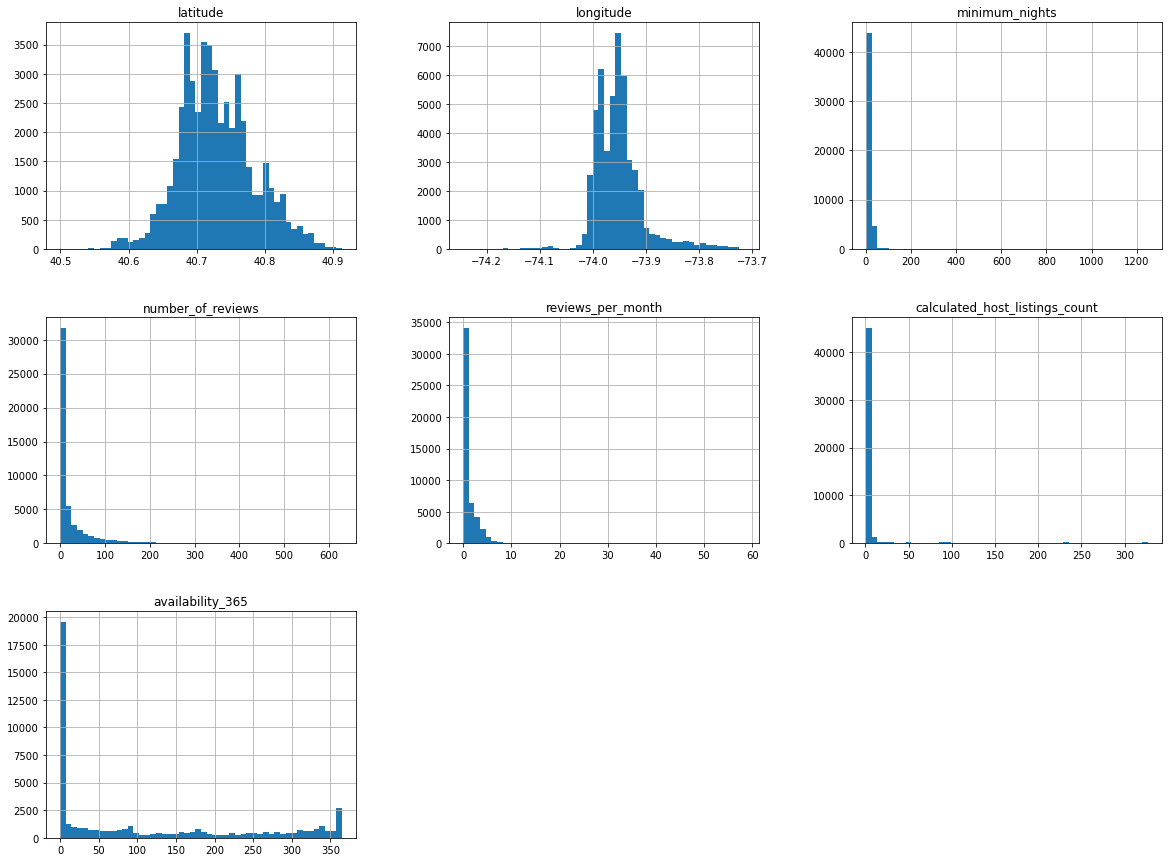

In [9]:
data.drop('price',axis=1).hist(figsize=(20, 15), bins=50);

#### Гистограмма целевого признака 

In [10]:
data['price'].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [11]:
min_price_thresold,max_price_thresold = data['price'].quantile([0.0001,0.9999])
min_price_thresold,max_price_thresold
data = data[(data['price'] > min_price_thresold) & (data['price'] < max_price_thresold)]
data.shape 

(48878, 11)

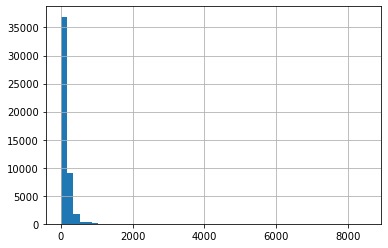

In [12]:
data['price'].hist(bins=50);

Сгладим распределение признака price, прологарифмировав его, так на гистаграмме видно, что есть много выбросов.

In [13]:
data['price'] = np.log(data['price'])

In [14]:
data['price'].describe()

count    48878.000000
mean         4.726481
std          0.696498
min          2.302585
25%          4.234107
50%          4.663439
75%          5.164786
max          9.047821
Name: price, dtype: float64

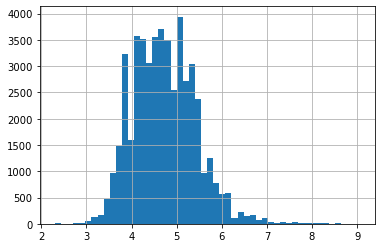

In [15]:
data['price'].hist(bins=50);

#### Корреляционная матрица

interval columns not set, guessing: ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

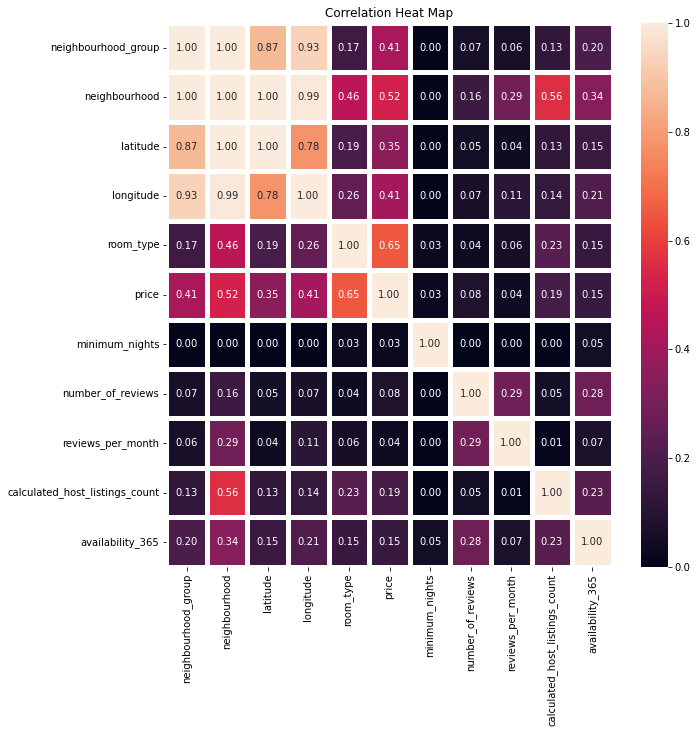

In [16]:
corr_matrix = data.phik_matrix()

f, ax = plt.subplots(figsize=(10, 10))
plt.title('Correlation Heat Map')

sns.heatmap(corr_matrix, annot=True, linewidths=5, fmt='.2f', ax=ax)

plt.show()

Есть мультиколлинеарность между neighbourhood и neighbourhood_group, latitude, longitude.

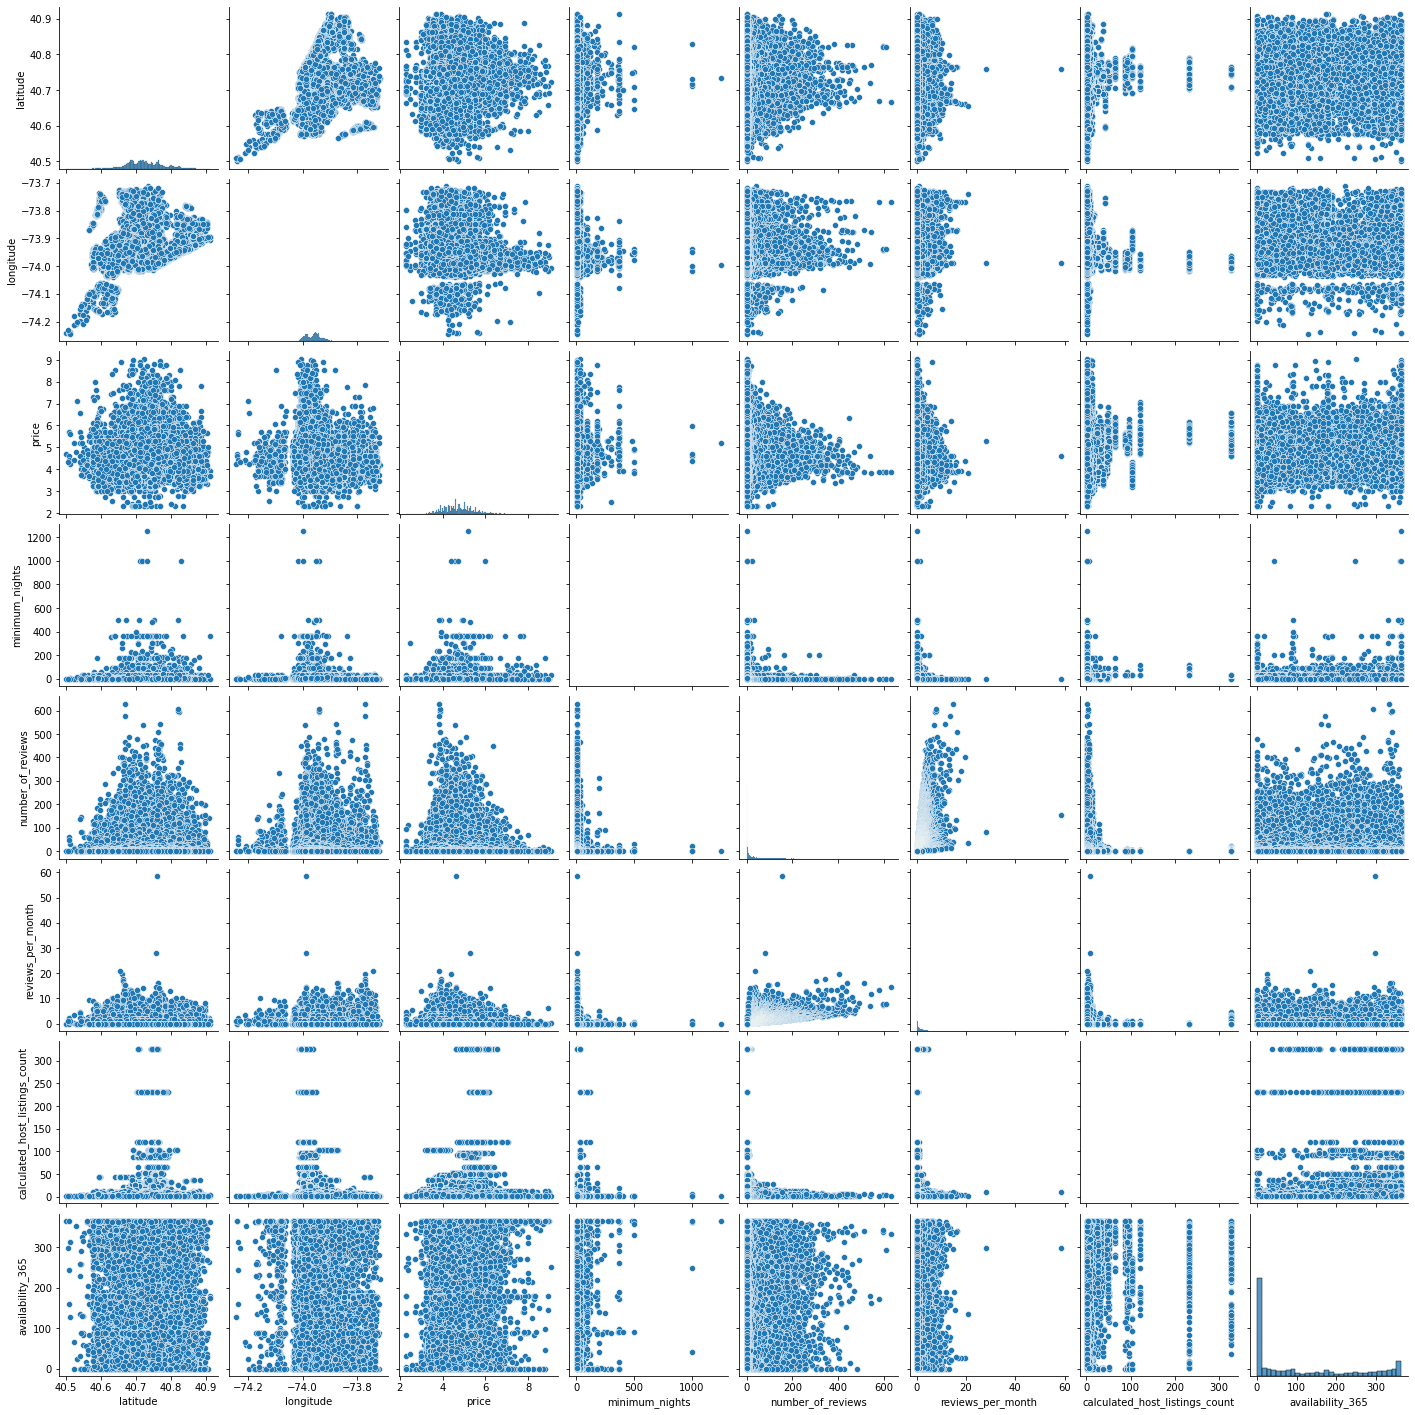

In [17]:
sns.pairplot(data);

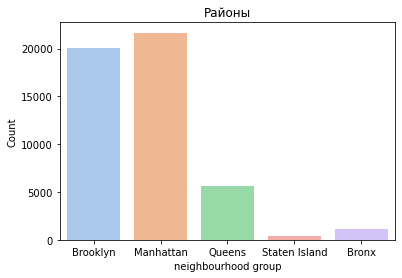

In [18]:
plt.figure(figsize=(6, 4))
sns.countplot(x = 'neighbourhood_group', data=data, palette='pastel')
plt.title('Районы')

plt.xlabel('neighbourhood group')
plt.ylabel('Count')
plt.show()

Количество объектов в районах Brooklyn и Manhattan гораздо больше, чем в остальных районах. Их можно объединить в одну категорию.

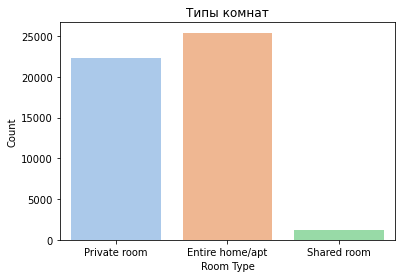

In [19]:
plt.figure(figsize=(6, 4))
sns.countplot(x = 'room_type', data= data, palette='pastel')
plt.title('Типы комнат')

plt.xlabel('Room Type')
plt.ylabel('Count')
plt.show()

Объектов с типом комнат Shared_room очень мало, их можно убрать из рассмотрения.

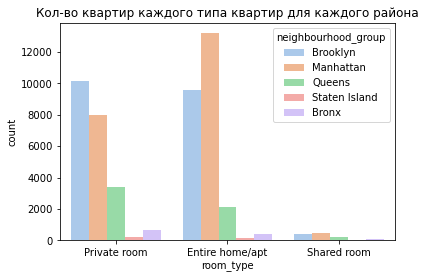

In [20]:
plt.title('Кол-во квартир каждого типа квартир для каждого района')
sns.countplot(x=data['room_type'],hue=data['neighbourhood_group'], palette='pastel');

Количество объектов в районах Brooklyn и Manhattan всех типов больше, чем в остальных районах.

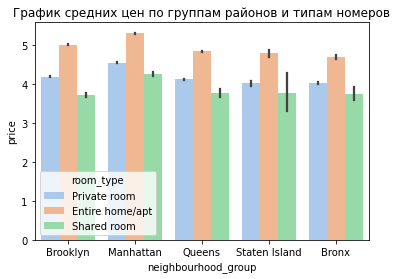

In [21]:
plt.figure(figsize=(6,4))
plt.title('График средних цен по группам районов и типам номеров')
sns.barplot(x = "neighbourhood_group", y = "price", hue = "room_type", data = data, palette='pastel');
plt.show()

Цена отдельных квартир выше во всех районах.

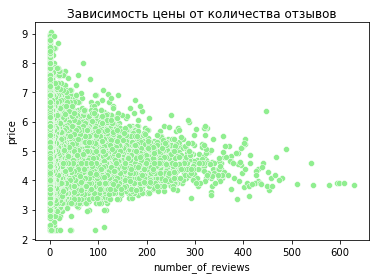

In [22]:
plt.figure(figsize=(6,4))
plt.title("Зависимость цены от количества отзывов")
sns.scatterplot(x = 'number_of_reviews',y = 'price',data = data,color='lightGreen')
plt.show()

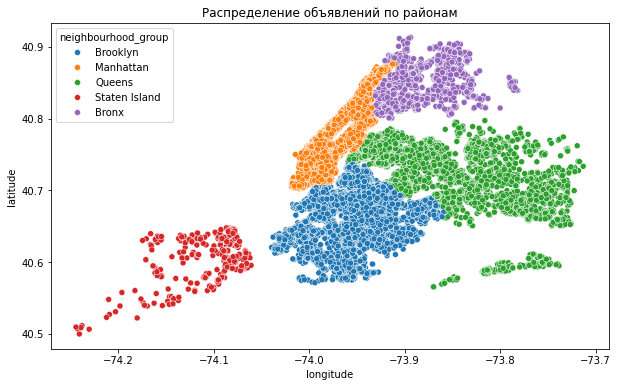

In [23]:
plt.figure(figsize= (10,6))
plt.title('Распределение объявлений по районам')

sns.scatterplot(x = data.longitude, y = data.latitude,hue=data.neighbourhood_group)
plt.show()

In [24]:
a_availability = data[data['availability_365']<=90].count()[0]
b_availability = data[(data['availability_365']>90) & (data['availability_365']<=180)].count()[0]
c_availability = data[(data['availability_365']>180) & (data['availability_365']<=270)].count()[0]
d_availability = data[(data['availability_365']>270)].count()[0]

Text(0.5, 1.0, 'Availability of Airbnb Rentals\nAs a % of the Calendar Year 2019')

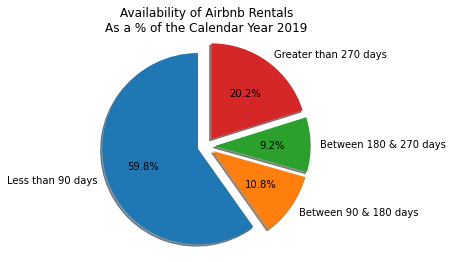

In [25]:
labels = 'Less than 90 days','Between 90 & 180 days','Between 180 & 270 days','Greater than 270 days'
sizes = a_availability,b_availability,c_availability,d_availability
explode = (.1,.1,.1,.1)

availability_pie = plt.pie(sizes,labels=labels,explode=explode,shadow=True,startangle=90,autopct='%1.1f%%',radius=1.1)
plt.title('Availability of Airbnb Rentals\n'+'As a % of the Calendar Year 2019')

In [26]:
df = data.copy(deep=True)

####  Признак neighbourhood

In [27]:
# Районы с небольшим количеством предложений убираем из рассмотрения
a = df['neighbourhood'].value_counts()
tail_neighbourhood_values = a[len(a)-100:]

for it in tail_neighbourhood_values.index :
    b = data[data['neighbourhood'] == it].index
    df = df.drop(index=b, axis=0)
df.shape 

(47885, 11)

In [28]:
data_original = df.copy(deep=True) 

In [29]:
data_original.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,5.003946,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,5.416100,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,5.010635,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,4.488636,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,4.382027,10,9,0.10,1,0


In [30]:
df.drop(["latitude", "longitude", 'neighbourhood'], axis=1, inplace=True) 
df.shape

(47885, 8)

### Первая модель

In [31]:
df.head()

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Private room,5.003946,1,9,0.21,6,365
1,Manhattan,Entire home/apt,5.416100,1,45,0.38,2,355
2,Manhattan,Private room,5.010635,3,0,0.00,1,365
3,Brooklyn,Entire home/apt,4.488636,1,270,4.64,1,194
4,Manhattan,Entire home/apt,4.382027,10,9,0.10,1,0


In [32]:
df_cat_rt = pd.get_dummies(df['room_type'], drop_first=True, prefix='room_type')

df = pd.concat([df.drop('room_type',axis=1),df_cat_rt], axis=1)

df_cat_ng = pd.get_dummies(df['neighbourhood_group'], drop_first=True, prefix='neighbourhood_group')
df = pd.concat([df.drop('neighbourhood_group',axis=1),df_cat_ng], axis=1)

df.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Private room,room_type_Shared room,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
0,5.003946,1,9,0.21,6,365,True,False,True,False,False,False
1,5.416100,1,45,0.38,2,355,False,False,False,True,False,False
2,5.010635,3,0,0.00,1,365,True,False,False,True,False,False
3,4.488636,1,270,4.64,1,194,False,False,True,False,False,False
4,4.382027,10,9,0.10,1,0,False,False,False,True,False,False


In [33]:
df.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Private room,room_type_Shared room,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
0,5.003946,1,9,0.21,6,365,True,False,True,False,False,False
1,5.416100,1,45,0.38,2,355,False,False,False,True,False,False
2,5.010635,3,0,0.00,1,365,True,False,False,True,False,False
3,4.488636,1,270,4.64,1,194,False,False,True,False,False,False
4,4.382027,10,9,0.10,1,0,False,False,False,True,False,False


In [34]:
num_columns = [ 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
              'calculated_host_listings_count', 'availability_365'] # 'latitude', 'longitude',

In [35]:
df_train, df_test = train_test_split(df, test_size = 0.3, random_state=123)

In [36]:
scaler = StandardScaler() # MinMaxScaler()  # RobustScaler()
scaler.fit(df_train[num_columns]) 

StandardScaler()

In [37]:
df_train_scale = scaler.transform(df_train[num_columns])
df_test_scale = scaler.transform(df_test[num_columns])

In [38]:
df_train[num_columns] = df_train_scale
df_test[num_columns] = df_test_scale

In [39]:
print(df_train.shape)
print(df_test.shape)  

(33519, 12)
(14366, 12)


In [40]:
y_train = df_train.price 
y_test = df_test.price 

X_train = df_train.drop('price', axis=1)
X_test = df_test.drop('price', axis=1)

In [41]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33519, 11), (14366, 11), (33519,), (14366,))

In [42]:
def print_metrics(y_test,y_pred):
    print('MAE:', metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred)))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred))))
    print('R2:',  metrics.r2_score(y_test, y_pred))

In [43]:
def dataframe_metrics(y_test,y_pred):
    stats = [
       metrics.mean_absolute_error(np.exp(y_test)-1, np.exp(y_pred)-1),
       np.sqrt(metrics.mean_squared_error(np.exp(y_test)-1, np.exp(y_pred)-1)),
       metrics.r2_score(np.exp(y_test), np.exp(y_pred)-1),
    ]
    return stats

In [44]:
simple_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2"]})

#### LinearRegression

In [45]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lin_reg = lin_reg.predict(X_test)

In [46]:
simple_metrics["lin_reg"] = dataframe_metrics(y_test, y_pred_lin_reg)
simple_metrics

,error_type,lin_reg
0,MAE,63.522197
1,RMSE,207.901508
2,R2,0.094291


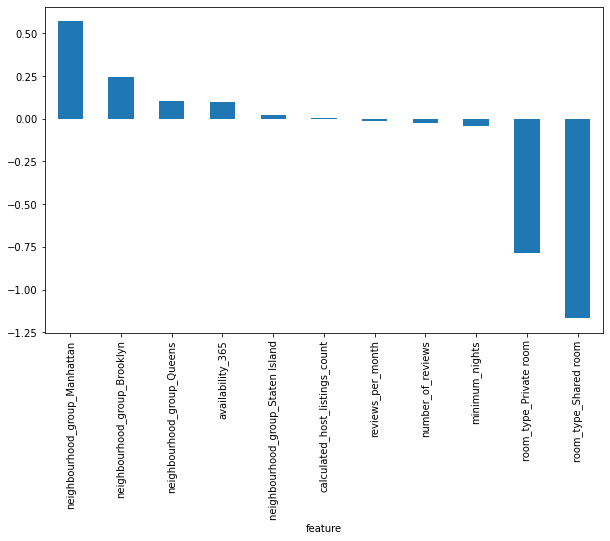

In [47]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": lin_reg.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

- Расположение в районах Manhattan, Brooklyn и Queens, а также высокое значение признака availability_365 положительно влияют на цену.
- Значения признака room_type  Private room и Shared room на цену влияют отрицательно. Цена комнат меньше цены отдельных квартир.

#### Lasso

In [48]:
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

In [49]:
simple_metrics["lasso"] = dataframe_metrics(y_test, y_pred_lasso)
simple_metrics

,error_type,lin_reg,lasso
0,MAE,63.522197,83.311139
1,RMSE,207.901508,221.871538
2,R2,0.094291,-0.031912


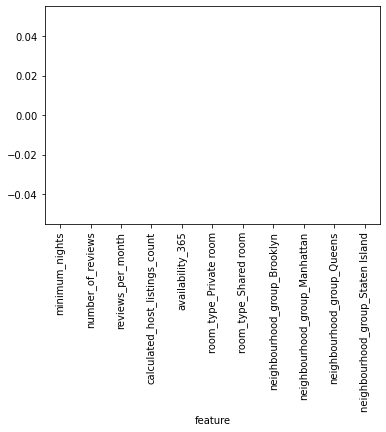

In [50]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": lasso.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar');

На графике видно, что важных признаков нет. Это получилось, потому что по умолчанию поставили слишком сильную регуляризацию.

#### Подбор гиперпараметра для Lasso-регрессии

In [51]:
# перебор параметра 
param_grid = {'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}
 
grid_lasso = Lasso() 

grid_cv_lasso = GridSearchCV(grid_lasso, param_grid, cv = 5)
grid_cv_lasso.fit(X_train, y_train)
print('Лучшее значение параметра:', grid_cv_lasso.best_params_)

y_pred_grid_lasso = grid_cv_lasso.predict(X_test)

Лучшее значение параметра: {'alpha': 0.001}


In [52]:
simple_metrics["grid_lasso"] = dataframe_metrics(y_test, y_pred_grid_lasso)
simple_metrics

,error_type,lin_reg,lasso,grid_lasso
0,MAE,63.522197,83.311139,63.515559
1,RMSE,207.901508,221.871538,208.032513
2,R2,0.094291,-0.031912,0.093138


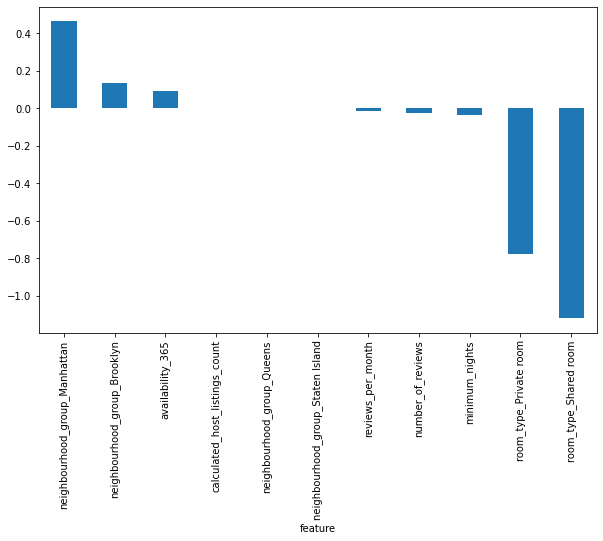

In [53]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": grid_cv_lasso.best_estimator_.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

- Районы Манхэттен и Бруклин, а также значение признака availability_365 положительно влияют на цену.
- Значения признака room_type  Private room и Shared room на цену влияют отрицательно.

#### LassoCV

In [54]:
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, y_train)
print('Лучшее значение параметра:', lasso_cv.alpha_)

y_pred_lasso_cv = lasso_cv.predict(X_test)

Лучшее значение параметра: 0.00019777067702340362


In [55]:
simple_metrics["lassoCV"] = dataframe_metrics(y_test, y_pred_lasso_cv)
simple_metrics

,error_type,lin_reg,lasso,grid_lasso,lassoCV
0,MAE,63.522197,83.311139,63.515559,63.518402
1,RMSE,207.901508,221.871538,208.032513,207.929056
2,R2,0.094291,-0.031912,0.093138,0.094049


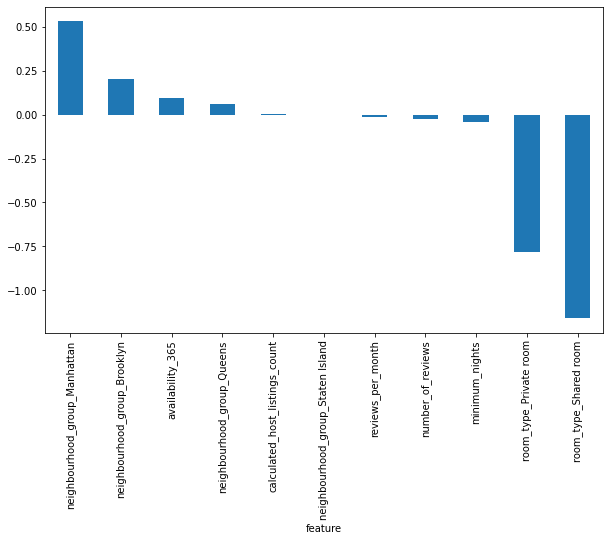

In [56]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": lasso_cv.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

- Расположение в районах Manhattan, Brooklyn и Queens, а также высокое значение признака availability_365 положительно влияют на цену.
- Значения признака room_type  Private room и Shared room на цену влияют отрицательно. Цена комнат сильно меньше цены отдельных квартир.

#### RidgeCV

In [57]:
ridgeCV = RidgeCV()
ridgeCV.fit(X_train, y_train)

y_pred_ridge = ridgeCV.predict(X_test)

In [58]:
simple_metrics["ridgeCV"] = dataframe_metrics(y_test, y_pred_ridge)
simple_metrics

,error_type,lin_reg,lasso,grid_lasso,lassoCV,ridgeCV
0,MAE,63.522197,83.311139,63.515559,63.518402,63.521495
1,RMSE,207.901508,221.871538,208.032513,207.929056,207.903987
2,R2,0.094291,-0.031912,0.093138,0.094049,0.094269


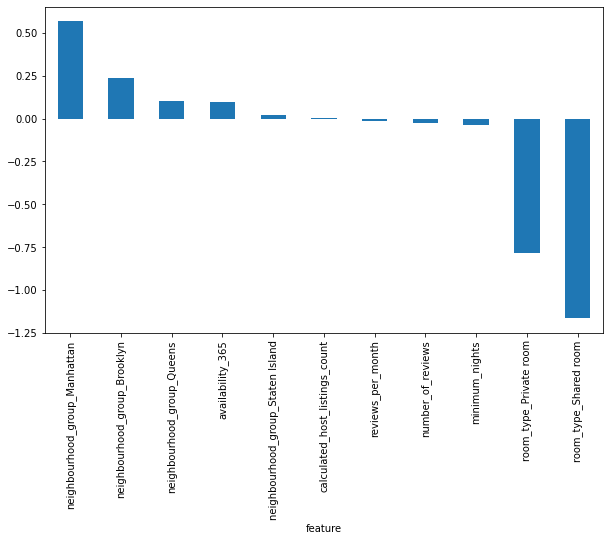

In [59]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": ridgeCV.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

- Расположение в районах Manhattan, Brooklyn и Queens, а также высокое значение признака availability_365 положительно влияют на цену.
- Значения признака room_type  Private room и Shared room на цену влияют отрицательно. Цена комнат сильно меньше цены отдельных квартир.

#### ElasticNetCV

In [60]:
elasticNetCV = ElasticNetCV()
elasticNetCV.fit(X_train, y_train)
y_pred_elasticNet = elasticNetCV.predict(X_test)


In [61]:
simple_metrics["elasticNetCV"] = dataframe_metrics(y_test, y_pred_elasticNet)
simple_metrics

,error_type,lin_reg,lasso,grid_lasso,lassoCV,ridgeCV,elasticNetCV
0,MAE,63.522197,83.311139,63.515559,63.518402,63.521495,63.515152
1,RMSE,207.901508,221.871538,208.032513,207.929056,207.903987,207.945210
2,R2,0.094291,-0.031912,0.093138,0.094049,0.094269,0.093906


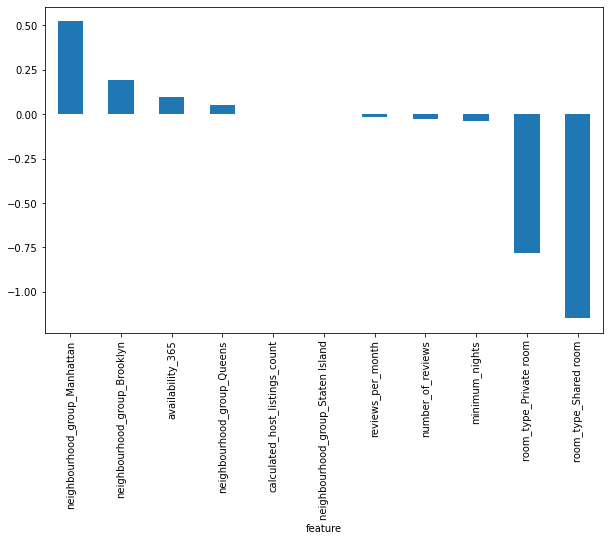

In [62]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": elasticNetCV.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

- Расположение в районах Manhattan, Brooklyn и Queens, а также высокое значение признака availability_365 положительно влияют на цену.
- Значения признака room_type  Private room и Shared room на цену влияют отрицательно. Цена комнат сильно меньше цены отдельных квартир.

### Выводы

In [63]:
simple_metrics

,error_type,lin_reg,lasso,grid_lasso,lassoCV,ridgeCV,elasticNetCV
0,MAE,63.522197,83.311139,63.515559,63.518402,63.521495,63.515152
1,RMSE,207.901508,221.871538,208.032513,207.929056,207.903987,207.945210
2,R2,0.094291,-0.031912,0.093138,0.094049,0.094269,0.093906


- Модель Lasso показывает самые плохие результаты по всем метрикам.

- Метрики MAE у моделей LinearRegression, RidgeCV хуже, чем у Lasso(grid), LassoCV и ElasticNetCV.
- Метрика RMSE у моделей Lasso(grid), LassoCV, ElasticNetCV хуже, чем LinearRegression и RidgeCV.
- Метрика R2 у моделей Lasso(grid) и ElasticNetCV хуже, чем у LinearRegression, LassoCV, RidgeCV.

Модели LinearRegression, LassoCV, RidgeCV показали лучшие результаты.

#### Интерпретируемость признаков:
- Расположение в районах Manhattan, Brooklyn и Queens, а также высокое значение признака availability_365 положительно влияют на цену.
- Значения признака room_type  Private room и Shared room на цену влияют отрицательно. Цена комнат сильно меньше цены отдельных квартир.

In [64]:
df = data_original

## Произведём дополнительные преобразования датасета

#### Признак minimum nights  

In [65]:
# Убираем крайние значения
min_nights_thresold,max_nights_thresold=df['minimum_nights'].quantile([0.001, 0.999])
min_nights_thresold,max_nights_thresold
#df = df[(df['minimum_nights'] > min_nights_thresold) & (df['minimum_nights'] < max_nights_thresold)]
print(' min_nights = ', round(min_nights_thresold))
print(' max_nights = ', round(max_nights_thresold))

 min_nights =  1
 max_nights =  355


    Попробовали удалить нижние и верхние выбросы в признаке minimum, метрики ухучшились.

#### Определение центра Манхэттена

In [66]:
df_mnht = df[df['neighbourhood_group']=='Manhattan']
df_mnht.shape

(21644, 11)

In [67]:
df_mnht.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,5.416100,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,5.010635,3,0,0.00,1,365
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,4.382027,10,9,0.10,1,0
5,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,5.298317,3,74,0.59,1,129
7,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,4.369448,2,430,3.47,1,220


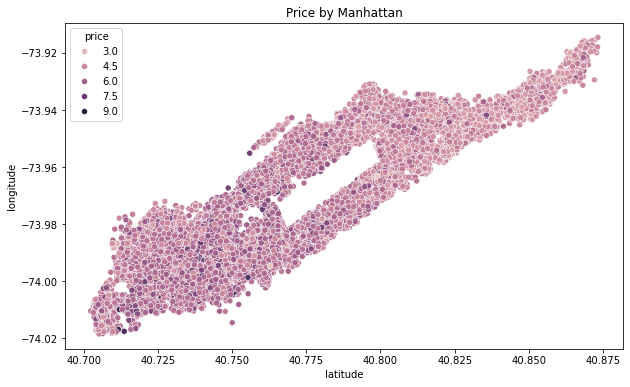

In [68]:
plt.figure(figsize= (10,6))
plt.title('Price by Manhattan')
sns.scatterplot(x = df_mnht['latitude'], y=df_mnht['longitude'], hue=df_mnht['price']);
plt.show()

In [69]:
df_mnht['longitude'].describe()

count    21644.000000
mean       -73.974642
std          0.022095
min        -74.018510
25%        -73.991703
50%        -73.980430
75%        -73.953898
max        -73.914580
Name: longitude, dtype: float64

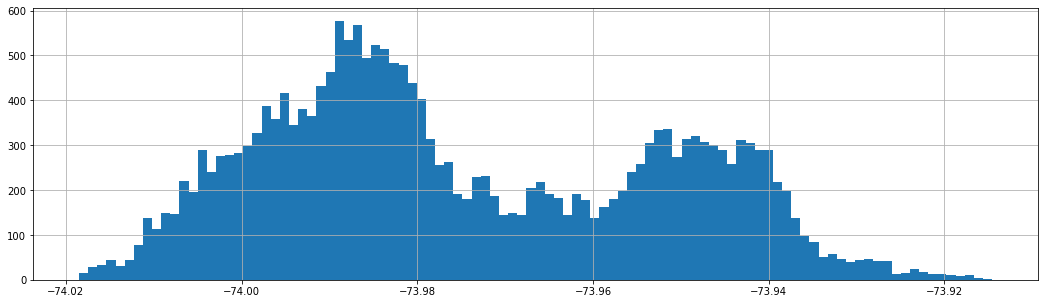

In [70]:
plt.figure(figsize= (18,5))
df_mnht['longitude'].hist(bins=100);

In [71]:
df_mnht['latitude'].describe()

count    21644.000000
mean        40.765005
std          0.038386
min         40.702340
25%         40.731808
50%         40.760855
75%         40.795050
max         40.873280
Name: latitude, dtype: float64

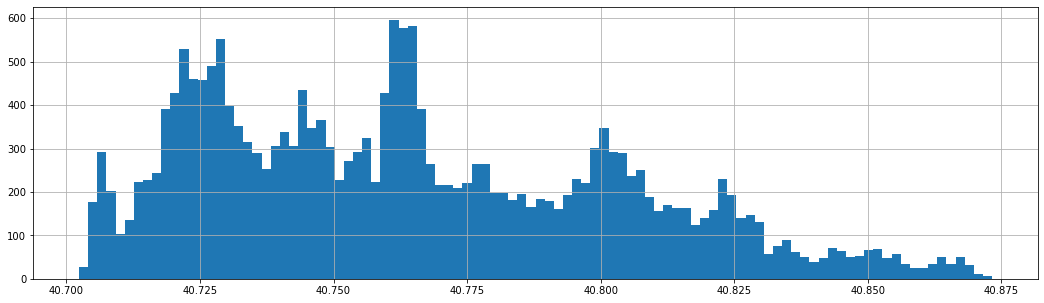

In [72]:
plt.figure(figsize= (18,5))
df_mnht['latitude'].hist(bins=100);

In [73]:
mnht_cntr_long = df_mnht['longitude'].median()
mnht_cntr_lat = df_mnht['latitude'].median()
mnht_cntr = (mnht_cntr_long, mnht_cntr_lat)
mnht_cntr

(-73.98043, 40.760855)

#### Добавляю столбец с евклид расстоянием до центра района

In [74]:
pnt1 = np.array(mnht_cntr)
df.loc[:, 'eucldn'] = 0.0
for it in df.index : 
    lng = df.loc[it]['longitude']
    lt = df.loc[it]['latitude']
    pnt2 = np.array((lng,lt))
    
    df.loc[it,'eucldn'] = np.linalg.norm(pnt1 - pnt2)

    Метрики значительно улучшились.

In [75]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,eucldn
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,5.003946,1,9,0.21,6,365,0.113651
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,5.416100,1,45,0.38,2,355,0.007969
2,Manhattan,Harlem,40.80902,-73.94190,Private room,5.010635,3,0,0.00,1,365,0.061680
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,4.488636,1,270,4.64,1,194,0.078486
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,4.382027,10,9,0.10,1,0,0.052400


#### Объединили три менее значимых по количеству данных района в один, со значением Other

In [76]:
df['neighbourhood_group'].replace('Bronx', 'Other', inplace=True)
df['neighbourhood_group'].replace('Queens', 'Other', inplace=True)
df['neighbourhood_group'].replace('Staten Island', 'Other', inplace=True)

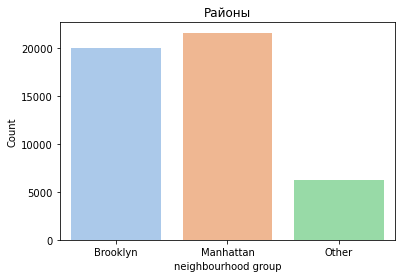

In [77]:
plt.figure(figsize=(6, 4))
sns.countplot(x = 'neighbourhood_group', data=df, palette='pastel')
plt.title('Районы')

plt.xlabel('neighbourhood group')
plt.ylabel('Count')
plt.show()

    Метрики улучшились.

#### Признак calculated_host_listings_count 

In [78]:
df['calculated_host_listings_count'].sort_values().unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  23,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  37,  39,  43,  47,  49,  50,  52,
        65,  87,  91,  96, 103, 121, 232, 327])

In [79]:
df['calculated_host_listings_count'].sort_values().value_counts(normalize=True).head(10)

calculated_host_listings_count
1      0.662337
2      0.135491
3      0.057763
4      0.029174
5      0.016769
6      0.011569
8      0.008520
7      0.007539
327    0.006829
9      0.004887
Name: proportion, dtype: float64

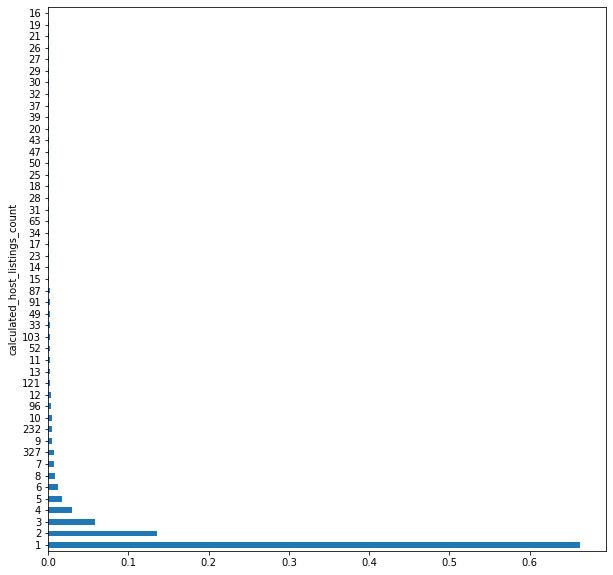

In [80]:
df['calculated_host_listings_count'].value_counts(normalize=True).plot.barh(figsize=(10,10));

In [81]:
df['calculated_host_listings_count'][df['calculated_host_listings_count'] > 3] = 'more_than_three_list'
df['calculated_host_listings_count'][df['calculated_host_listings_count'] == 1] = 'one_list'
df['calculated_host_listings_count'][df['calculated_host_listings_count'] == 2] = 'two_list'
df['calculated_host_listings_count'][df['calculated_host_listings_count'] == 3] = 'three_list'

In [82]:
df['calculated_host_listings_count'].unique()

array(['more_than_three_list', 'two_list', 'one_list', 'three_list'],
      dtype=object)

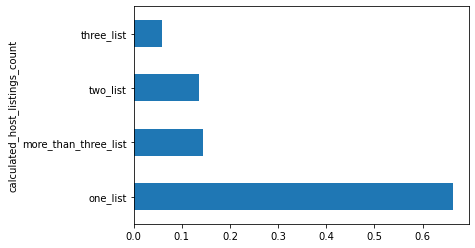

In [83]:
df['calculated_host_listings_count'].value_counts(normalize=True).plot.barh();

    Метрики улучшились.

#### Признак minimum_nights

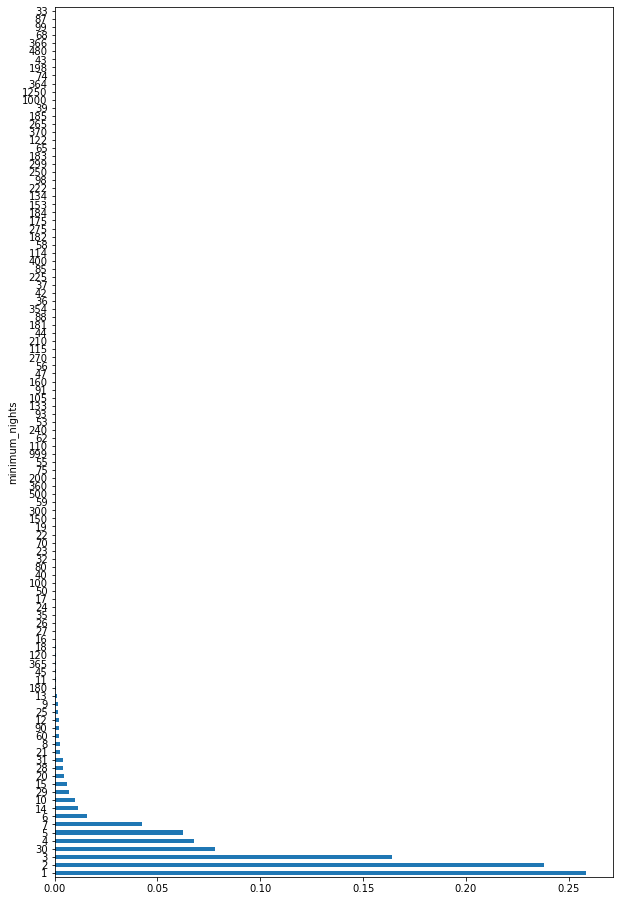

In [84]:
df['minimum_nights'].value_counts(normalize=True).plot.barh(figsize=(10,16));

In [85]:
df['minimum_nights'][df['minimum_nights'] > 3] = 'more_than_three_nights'
df['minimum_nights'][df['minimum_nights'] == 1] = 'one_nights'
df['minimum_nights'][df['minimum_nights'] == 2] = 'two_nights'
df['minimum_nights'][df['minimum_nights'] == 3] = 'three_nights'

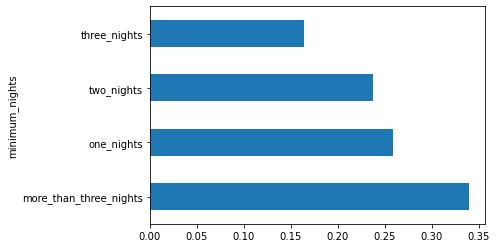

In [86]:
df['minimum_nights'].value_counts(normalize=True).plot.barh();

#### Матрица корреляции с признаком eucldn

interval columns not set, guessing: ['latitude', 'longitude', 'price', 'number_of_reviews', 'reviews_per_month', 'availability_365', 'eucldn']


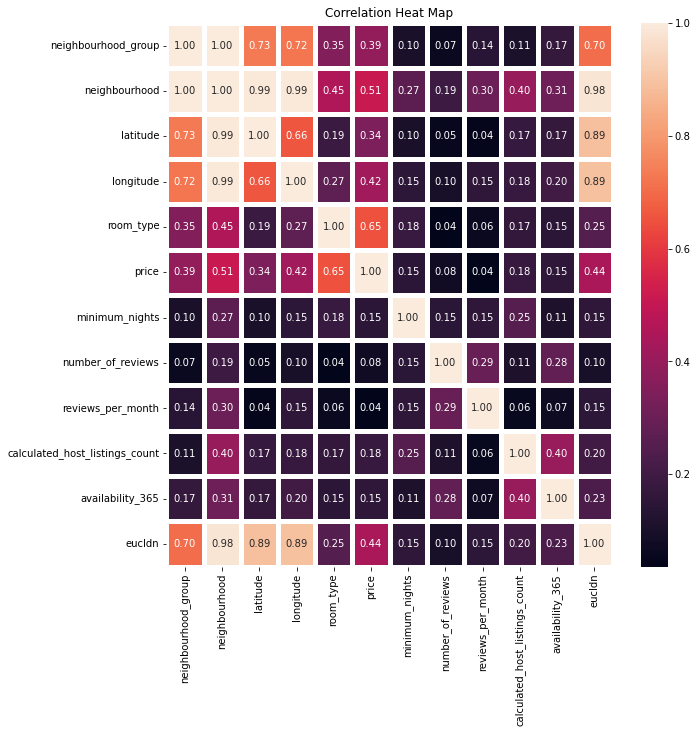

In [87]:
corr_matrix = df.phik_matrix()
f, ax = plt.subplots(figsize=(10, 10))
plt.title('Correlation Heat Map')

sns.heatmap(corr_matrix, annot=True, linewidths=5, fmt='.2f', ax=ax)
plt.show()

#### Убраем сильно скоррелированные latitude, longitude, neighbourhood

In [88]:
num_columns

['minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [89]:
df.drop(["latitude", "longitude", 'neighbourhood'], axis=1, inplace=True)
df.shape

(47885, 9)

In [90]:
df.head()

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,eucldn
0,Brooklyn,Private room,5.003946,one_nights,9,0.21,more_than_three_list,365,0.113651
1,Manhattan,Entire home/apt,5.416100,one_nights,45,0.38,two_list,355,0.007969
2,Manhattan,Private room,5.010635,three_nights,0,0.00,one_list,365,0.061680
3,Brooklyn,Entire home/apt,4.488636,one_nights,270,4.64,one_list,194,0.078486
4,Manhattan,Entire home/apt,4.382027,more_than_three_nights,9,0.10,one_list,0,0.052400


In [91]:
num_columns = [ 'number_of_reviews', 'reviews_per_month', 'eucldn', 'availability_365']
cat_columns = ['neighbourhood_group',  'minimum_nights', 'room_type',
               'calculated_host_listings_count']

In [92]:
measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2"]})

#### Убираем из рассмотрения  Shared room 

In [93]:
df[df['room_type'] == 'Shared room' ]['room_type'].count()/len(df)*100

2.3284953534509762

Объектов со значением признака room_type = 'Shared room' - 2% 

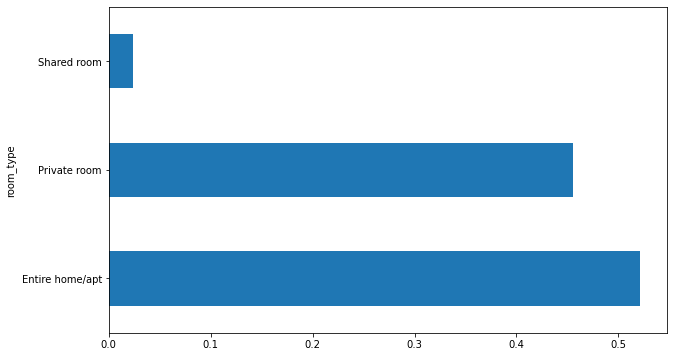

In [94]:
df['room_type'].value_counts(normalize=True).plot.barh(figsize=(10, 6));

In [95]:
#df['room_type'] = df['room_type'].apply(lambda x: x if x == 'Shared room' else "Private room")

In [96]:
df = df.query( 'room_type != \'Shared room\' ')

    Признак room_type = 'Shared room' это 2% данных.
    - Присоединили их к признаку room_type = 'Private room', метрики стали хуже.
    - Удалили объекты с признаком room_type = 'Private room' из рассмотрения, метрики стали лучше.

In [97]:
df = pd.get_dummies(df, columns=cat_columns, drop_first=True)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['price'], axis=1), 
    df['price'],
    test_size=0.3,
    random_state=123
)

In [99]:
scaler = StandardScaler()

X_train_scaled_numeric = scaler.fit_transform(X_train[num_columns])
X_test_scaled_numeric = scaler.transform(X_test[num_columns])

X_train[num_columns] = X_train_scaled_numeric
X_test[num_columns] = X_test_scaled_numeric

#### LinearRegression

In [100]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin_reg = lin_reg.predict(X_test)

measured_metrics["lin_reg"] = dataframe_metrics(y_test, y_pred_lin_reg)
measured_metrics

,error_type,lin_reg
0,MAE,61.701459
1,RMSE,192.385330
2,R2,0.116748


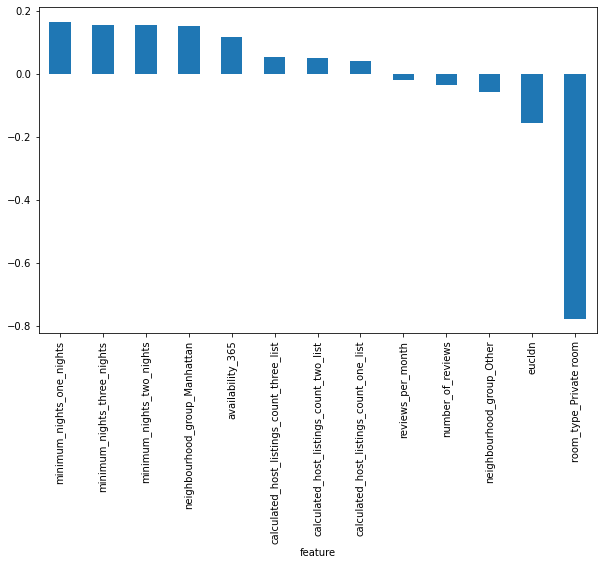

In [101]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": lin_reg.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

- Признак количество ночей(1,2,3), расположение в районе Manhattan и availability_365 положительно влияют на цену. Возможность остановится на 1-3 ночи в Манхэттон в любое время повышает цену.
- Значения признака room_type = Private_room, eucldn, расположение в районах не Бруклин и не Манхэттен на цену влияют отрицательно. Цена комнат сильно меньше цены отдельных квартир. Большое расстояние до центра района Манхэттен негативно влияет на цену.

#### Lasso

In [102]:
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

In [103]:
measured_metrics["lasso"] = dataframe_metrics(y_test, y_pred_lasso)
measured_metrics

,error_type,lin_reg,lasso
0,MAE,61.701459,83.165431
1,RMSE,192.385330,208.208517
2,R2,0.116748,-0.034966


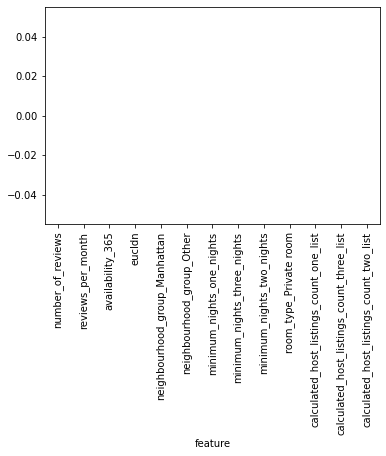

In [104]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": lasso.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar');

На графике видно, что важных признаков нет. Это получилось, потому что по умолчанию поставили слишком сильную регуляризацию.

#### Подбор гиперпараметра для Lasso-регрессии

In [105]:
param_grid = {'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}

grid_lasso = Lasso() 

grid_cv_lasso = GridSearchCV(grid_lasso, param_grid, cv = 5)
grid_cv_lasso.fit(X_train, y_train)
print('Лучшее значение параметра:', grid_cv_lasso.best_params_)

y_pred_grid_lasso = grid_cv_lasso.predict(X_test)

Лучшее значение параметра: {'alpha': 0.001}


In [106]:
measured_metrics["grid_lasso"] = dataframe_metrics(y_test, y_pred_grid_lasso)
measured_metrics

,error_type,lin_reg,lasso,grid_lasso
0,MAE,61.701459,83.165431,61.708061
1,RMSE,192.385330,208.208517,192.508176
2,R2,0.116748,-0.034966,0.115611


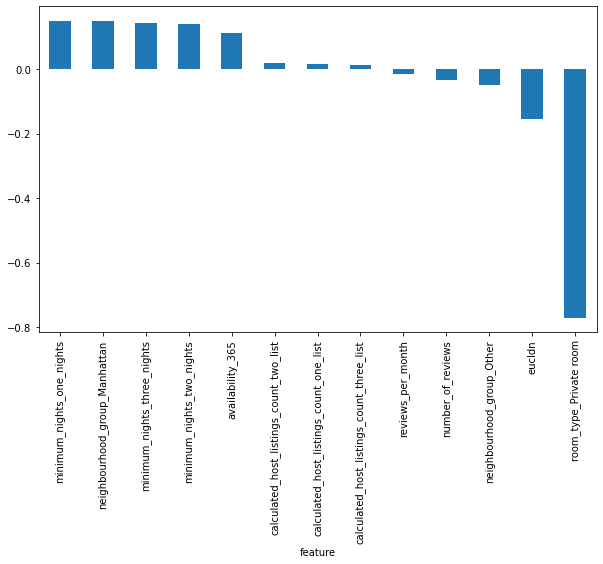

In [107]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": grid_cv_lasso.best_estimator_.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

- Признак количество ночей(1,2,3), расположение в районе Manhattan и availability_365 положительно влияют на цену. Возможность остановится на 1-3 ночи в Манхэттон в любое время повышает цену.
- Значения признака room_type = Private_room, eucldn, расположение в районах не Бруклин и не Манхэттен на цену влияют отрицательно. Цена комнат сильно меньше цены отдельных квартир. Большое расстояние до центра района Манхэттен негативно влияет на цену.

#### LassoCV

In [108]:
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, y_train)
print('Лучшее значение параметра:', lasso_cv.alpha_)
y_pred_lasso = lasso_cv.predict(X_test)

Лучшее значение параметра: 0.0002676946045136168


In [109]:
measured_metrics["lasso_cv"] = dataframe_metrics(y_test, y_pred_lasso)
measured_metrics

,error_type,lin_reg,lasso,grid_lasso,lasso_cv
0,MAE,61.701459,83.165431,61.708061,61.699491
1,RMSE,192.385330,208.208517,192.508176,192.416821
2,R2,0.116748,-0.034966,0.115611,0.116456


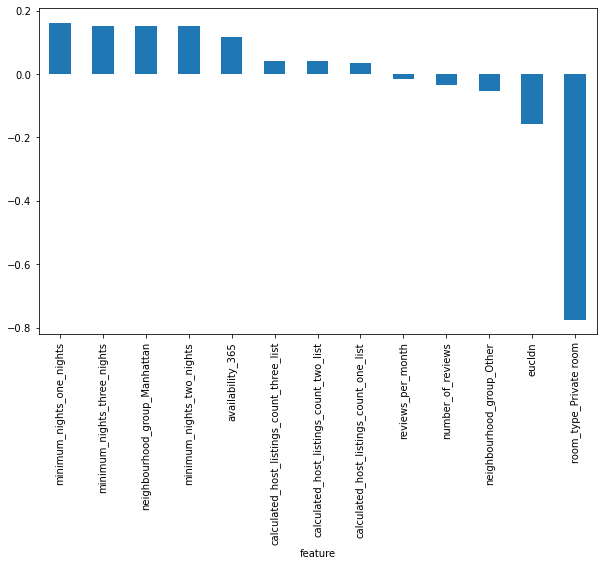

In [110]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": lasso_cv.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

- Признак количество ночей(1,2,3), расположение в районе Manhattan и availability_365 положительно влияют на цену. Возможность остановится на 1-3 ночи в Манхэттон в любое время повышает цену.
- Значения признака room_type = Private_room, eucldn, расположение в районах не Бруклин и не Манхэттен на цену влияют отрицательно. Цена комнат сильно меньше цены отдельных квартир. Большое расстояние до центра района Манхэттен негативно влияет на цену.

#### RidgeCV

In [111]:
ridgeCV = RidgeCV()
ridgeCV.fit(X_train, y_train)
y_pred_ridge = ridgeCV.predict(X_test)

In [112]:
measured_metrics["ridgeCV"] = dataframe_metrics(y_test, y_pred_ridge)
measured_metrics

,error_type,lin_reg,lasso,grid_lasso,lasso_cv,ridgeCV
0,MAE,61.701459,83.165431,61.708061,61.699491,61.697558
1,RMSE,192.385330,208.208517,192.508176,192.416821,192.394379
2,R2,0.116748,-0.034966,0.115611,0.116456,0.116663


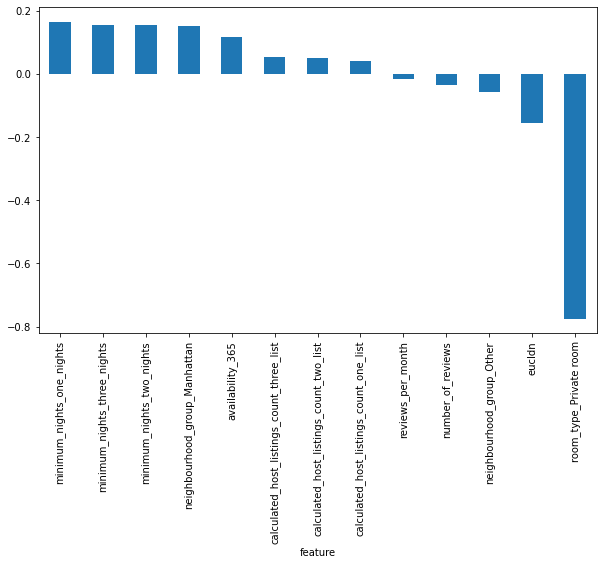

In [113]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": ridgeCV.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

- Признак количество ночей(1,2,3), расположение в районе Manhattan и availability_365 положительно влияют на цену. Возможность остановится на 1-3 ночи в Манхэттон в любое время повышает цену.
- Значения признака room_type = Private_room, eucldn , расположение в районах не Бруклин и не Манхэттен на цену влияют отрицательно. Цена комнат сильно меньше цены отдельных квартир. Большое расстояние до центра района Манхэттен негативно влияет на цену.

#### ElasticNetCV

In [114]:
elasticNetCV = ElasticNetCV()
elasticNetCV.fit(X_train, y_train)
y_pred_elasticNet = elasticNetCV.predict(X_test)

In [115]:
measured_metrics["elasticNetCV"] = dataframe_metrics(y_test, y_pred_elasticNet)
measured_metrics

,error_type,lin_reg,lasso,grid_lasso,lasso_cv,ridgeCV,elasticNetCV
0,MAE,61.701459,83.165431,61.708061,61.699491,61.697558,61.696398
1,RMSE,192.385330,208.208517,192.508176,192.416821,192.394379,192.424764
2,R2,0.116748,-0.034966,0.115611,0.116456,0.116663,0.116382


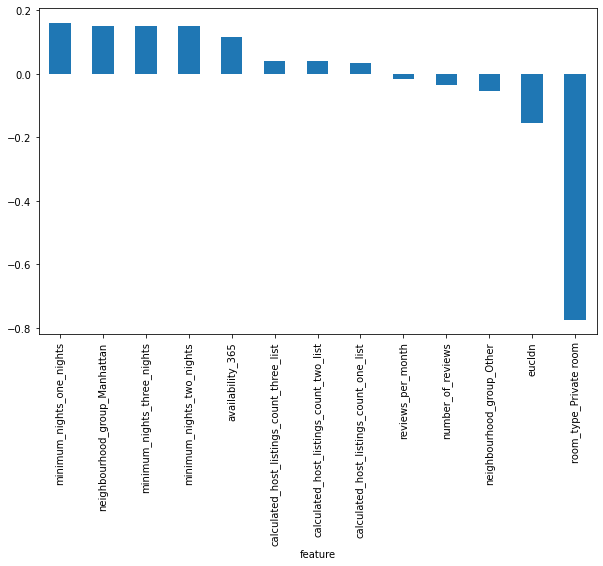

In [116]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": elasticNetCV.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

- Признак количество ночей(1,2,3), расположение в районе Manhattan и availability_365 положительно влияют на цену. Возможность остановится на 1-3 ночи в Манхэттон в любое время повышает цену.
- Значения признака room_type = Private_room, eucldn, расположение в районах не Бруклин и не Манхэттен на цену влияют отрицательно. Цена комнат сильно меньше цены отдельных квартир. Большое расстояние до центра района Манхэттен негативно влияет на цену.

### Результаты

#### До изменений:

In [117]:
simple_metrics

,error_type,lin_reg,lasso,grid_lasso,lassoCV,ridgeCV,elasticNetCV
0,MAE,63.522197,83.311139,63.515559,63.518402,63.521495,63.515152
1,RMSE,207.901508,221.871538,208.032513,207.929056,207.903987,207.945210
2,R2,0.094291,-0.031912,0.093138,0.094049,0.094269,0.093906


#### После изменений:

In [118]:
measured_metrics

,error_type,lin_reg,lasso,grid_lasso,lasso_cv,ridgeCV,elasticNetCV
0,MAE,61.701459,83.165431,61.708061,61.699491,61.697558,61.696398
1,RMSE,192.385330,208.208517,192.508176,192.416821,192.394379,192.424764
2,R2,0.116748,-0.034966,0.115611,0.116456,0.116663,0.116382


- Модель Lasso показывает самые плохие результаты по всем метрикам.

- Метрики MAE у моделей LinearRegression, Lasso(grid) хуже, чем у RidgeCV, ElasticNetCV и LassoCV.
- Метрика RMSE у моделей Lasso(grid), LassoCV, ElasticNetCV хуже, чем у LinearRegression и RidgeCV.
- Метрика R2 у моделей LinearRegression, LassoCV, RidgeCV немного хуже, чем у Lasso(grid) и ElasticNetCV.

Модели *RidgeCV*  и *ElasticNetCV* показали лучшие результаты.

### Выводы

До преобразований: Модели *LinearRegression*, *LassoCV*, *RidgeCV* показали лучшие результаты.

После преобразований: Модели *RidgeCV*  и *ElasticNetCV* показали лучшие результаты.

#### Изменения  

  - Прологарифмировали целевой признак.
  - При использовании разных скелеров(MinMaxScaler, StandartScaler, RobustScaler) результаты почти одинаковые.
  - При удалении нижних и верхних выбросов в признаке minimum_nights, метрики ухучшились.
  - При присоединили room_type = 'Shared room' к признаку room_type = 'Private room', метрики ухучшились.


  - Ввели признак с евклидовым расстоянием до центра района Манхэттена, метрики значительно улучшились.
  - Удалили объекты с признаком room_type = 'Shared room'(2% данных) из рассмотрения, метрики стали лучше.
  - Объединили три менее значимых по количеству данных района в один, со значением Other, метрики стали лучше.
  - Признак calculated_host_listings_count сделали категориальным, разбив его значения на 4 категории. 
  - Признак minimum_nights сделали категориальным,разбив его значения на 4 категории. 

#### Интерпритация признаков
    Почти во всех моделях(кроме Lasso) положительное и отрицательное влияние оказывают одни и те же признаки.
- Признак количество ночей(1,2,3), расположение в районе Manhattan и availability_365 положительно влияют на цену. Возможность остановится на 1-3 ночи в Манхэттон в любое время повышает цену объекта.
- Значения признака room_type = Private_room, eucldn, расположение в районах не Бруклин и не Манхэттен на цену влияют отрицательно. Цена комнат сильно меньше цены отдельных квартир. Большое расстояние до центра района Манхэттен также негативно влияет на цену.